Linear regression to predict streamflow. Streamflow is divided by 24 to match forcing resolution

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn import metrics, svm, neural_network, ensemble
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
from src import load_data, evaluate

In [2]:
data_runoff = load_data.load_discharge_gr4j_vic()

/home/mgauch/runoff-nn/src/load_data.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(os.path.join(dir, f), skiprows=2, skipfooter=1, index_col=False, header=None, names=['runoff'], na_values='-1.2345')
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [3]:
data_runoff[pd.isna(data_runoff['runoff'])].groupby(['station'])['date'].count()  # Count NAs per station

station
02GC018       44
02GG013       31
04214500    1003
Name: date, dtype: int64

In [4]:
# For each station, read which grid cells belong to its subwatershed
station_cell_mapping = pd.read_csv('station_cell_mapping.csv', skiprows=1, names=['station', 'lat', 'lon', 'row', 'col', 'area'])

In [5]:
rdrs_data = load_data.load_rdrs_forcings()

In [6]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7 * 24
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history // 24 + 1)
use_runoff_history = False

predictions = {}
actuals = {}
for station in data_runoff['station'].unique():
    print(station)
    station_data = data_runoff[data_runoff['station'] == station].set_index('date')
    station_cell_ids = 39 * station_cell_mapping[station_cell_mapping['station'] == station]['col'] \
        + station_cell_mapping[station_cell_mapping['station'] == station]['row']
    station_rdrs = rdrs_data.filter(regex='_(' + '|'.join(map(lambda x: str(x), station_cell_ids)) + ')$', axis=1)
    
    if any(station_data['runoff'].isna()):
        station_data = station_data[~pd.isna(station_data['runoff'])]
        print('Station', station, 'had NA runoff values')
    station_data = station_data.resample('1H').ffill()
    station_data['runoff'] = station_data['runoff'] / 24
    
    station_data = station_data.join(station_rdrs)
    for i in range(1, history + 1):
        station_data = station_data.join(station_rdrs.shift(i, axis=0), rsuffix='_-{}'.format(i))
        if use_runoff_history:
            station_data['runoff_-{}'.format(i)] = station_data['runoff'].shift(i, axis=0)
    
    station_train = station_data.loc[train_start : '2013-12-31']
    station_test = station_data.loc['2014-01-01' : '2014-12-31']
    print('  Fitting model')
    m = linear_model.LinearRegression()
    m.fit(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff'])
    
    station_test = station_test[~pd.isna(station_test['runoff'])]
    if len(station_test) == 0:
        print('Skipping', station)
        continue
        
    predict = pd.DataFrame(index=station_test.index)
    predict = predict.join(station_test.drop(['station', 'runoff'], axis=1))
    predict['runoff'] = np.nan
    if use_runoff_history:
        for i in range(history):
            for j in range(i + 1, history + 1):
                predict.iloc[i]['runoff_-{}'.format(j)] = station_test.iloc[i]['runoff_-{}'.format(j)]
    print('  Predicting')
    if not use_runoff_history:
        predict['runoff'] = m.predict(predict.drop('runoff', axis=1))
    else:
        for i in range(len(predict)):
            predict.iloc[i]['runoff'] = m.predict([predict.iloc[i].drop('runoff')])[0]
            for j in range(1, history + 1):
                if (i + j) >= len(predict):
                    break
                predict.iloc[i + j]['runoff_-{}'.format(j)] = predict.iloc[i]['runoff']
    predictions[station] = predict
    actuals[station] = station_test['runoff']

04159492
  Fitting model
  Predicting
04200500
  Fitting model
  Predicting
04161820
  Fitting model
  Predicting
04174500
  Fitting model
  Predicting
02GC010
  Fitting model
  Predicting
02GE007
  Fitting model
  Predicting
02GD004
  Fitting model
  Predicting
04214500
Station 04214500 had NA runoff values
  Fitting model
  Predicting
04213000
  Fitting model
  Predicting
02GG009
  Fitting model
  Predicting
02GA010
  Fitting model
  Predicting
04176500
  Fitting model
  Predicting
04177000
  Fitting model
  Predicting
02GA047
  Fitting model
  Predicting
02GC018
Station 02GC018 had NA runoff values
  Fitting model
  Predicting
04166500
  Fitting model
  Predicting
04207200
  Fitting model
  Predicting
04160600
  Fitting model
  Predicting
04215000
  Fitting model
  Predicting
02GA018
  Fitting model
  Predicting
02GG006
  Fitting model
  Predicting
04193500
  Fitting model
  Predicting
02GC007
  Fitting model
  Predicting
04208504
  Fitting model
  Predicting
04199000
  Fitting mode

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


04159492 	NSE: (clipped to 0) -0.8429257035008442
04200500 	NSE: (clipped to 0) 0.41466639287734897
04161820 	NSE: (clipped to 0) -0.00043660855576233004
04174500 	NSE: (clipped to 0) -0.5661191265983851
02GC010 	NSE: (clipped to 0) 0.3216645188892422
02GE007 	NSE: (clipped to 0) 0.28754251940300657
02GD004 	NSE: (clipped to 0) 0.16939031851916142
04214500 	NSE: (clipped to 0) -1.826889977595116
04213000 	NSE: (clipped to 0) 0.21746774019653214
02GG009 	NSE: (clipped to 0) 0.012332881922225924
02GA010 	NSE: (clipped to 0) 0.207049004848741
04176500 	NSE: (clipped to 0) -1.6831183076035758
04177000 	NSE: (clipped to 0) -0.030609832611318222
02GA047 	NSE: (clipped to 0) 0.46036964243008704
02GC018 	NSE: (clipped to 0) 0.23871635877843322
04166500 	NSE: (clipped to 0) 0.31303416468379963
04207200 	NSE: (clipped to 0) 0.4214934144750655
04160600 	NSE: (clipped to 0) 0.3215395478079962
04215000 	NSE: (clipped to 0) 0.3161656823437148
02GA018 	NSE: (clipped to 0) 0.3384585137162963
02GG006 	

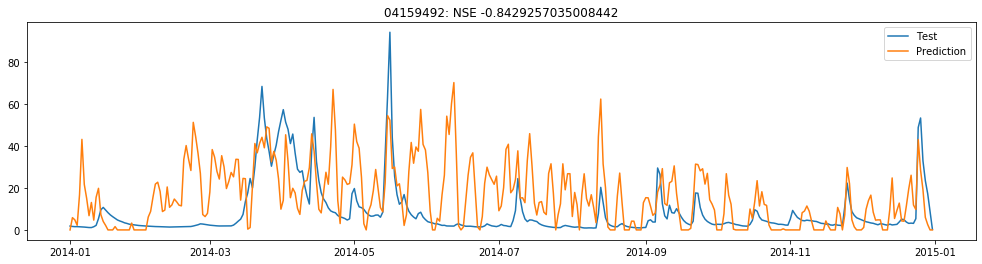

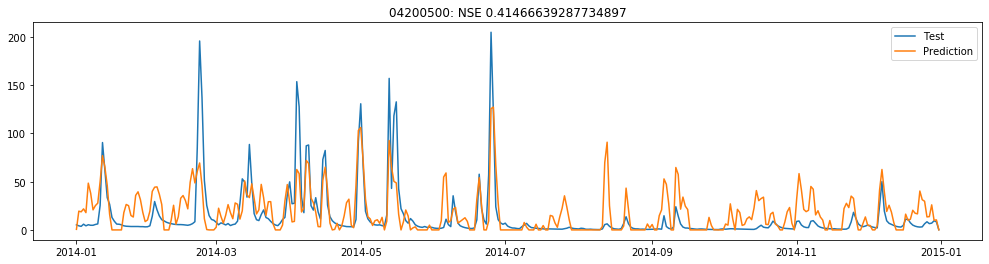

In [7]:
# Evaluate each station
nse_list = []
plot_list = ['04159492', '04200500']
for station, predict in predictions.items():
    nse = evaluate.evaluate_hourly(station, predict['runoff'], actuals[station], clip_before_aggregate=False, plot=station in plot_list)
    nse_list.append(nse)
    
    print(station, '\tNSE: (clipped to 0)', nse_list[-1])
    
print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))